# ANÁLISIS DE DATOS NO ESTRUCTURADOS
## TRABAJO IMAGEN
### NOTEBOOK EDA

# EDA: Dataset de Vehículos

Recorremos `./data/vehicle/Vehicles/`, extraemos metadatos y generamos:

1. Estadísticas generales  
2. Distribución de clases  
3. Histogramas de tamaño y aspect ratio  
4. Histogramas de píxeles (gris y RGB)  
5. Mosaicos de ejemplos  
6. Media/desviación por canal  
7. PCA sobre mini-imágenes


In [1]:
# 1) Imports y configuración
import os
from glob import glob
import random

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

# Ajustes globales
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)


In [6]:
# 2) Parámetros del dataset y carpeta de salidas
ROOT_DIR  = "./data/vehicle/Vehicles"   # ruta a las subcarpetas: Auto Rickshaws, Bikes, Cars, ...
OUT_DIR   = "./outputs/eda_vehicle"
SAMPLE_SZ = 100       # para histogramas de píxeles y PCA
MOSAIC_N  = 9         # nº de imágenes por mosaico

os.makedirs(OUT_DIR, exist_ok=True)


In [8]:
# 3) Recopilar metadatos en un DataFrame
records = []
for cls in os.listdir(ROOT_DIR):
    cls_dir = os.path.join(ROOT_DIR, cls)
    if not os.path.isdir(cls_dir): continue
    for f in glob(os.path.join(cls_dir, "*")):
        try:
            with Image.open(f) as img:
                w, h = img.size
                mode     = img.mode
                channels = len(img.getbands())
            size_b = os.path.getsize(f)
        except:
            continue
        records.append({
            "filepath": f,
            "class": cls,
            "width": w,
            "height": h,
            "aspect_ratio": w/h if h else np.nan,
            "mode": mode,
            "channels": channels,
            "size_bytes": size_b
        })

df = pd.DataFrame(records)
print(f"Total imágenes: {len(df)} | Clases: {df['class'].nunique()}")
df.head()


Total imágenes: 5590 | Clases: 7


,filepath,class,width,height,aspect_ratio,mode,channels,size_bytes
0,./data/vehicle/Vehicles\Auto Rickshaws\Auto Ri...,Auto Rickshaws,140,140,1.000000,RGB,3,4963
1,./data/vehicle/Vehicles\Auto Rickshaws\Auto Ri...,Auto Rickshaws,1920,1080,1.777778,RGB,3,175728
2,./data/vehicle/Vehicles\Auto Rickshaws\Auto Ri...,Auto Rickshaws,416,416,1.000000,RGB,3,25264
3,./data/vehicle/Vehicles\Auto Rickshaws\Auto Ri...,Auto Rickshaws,162,119,1.361345,RGB,3,3147
4,./data/vehicle/Vehicles\Auto Rickshaws\Auto Ri...,Auto Rickshaws,299,168,1.779762,RGB,3,7431


In [9]:
# 4) Guardar metadatos
csv_path = os.path.join(OUT_DIR, "metadata.csv")
df.to_csv(csv_path, index=False)
print("Metadatos en:", csv_path)


Metadatos en: ./outputs/eda_vehicle\metadata.csv


In [10]:
# 5) Estadísticas generales
print(df['class'].value_counts())
print("\nRango anchuras:", df['width'].min(), "-", df['width'].max())
print("Rango alturas:  ", df['height'].min(), "-", df['height'].max())
print("Aspect ratio (w/h):", df['aspect_ratio'].min(), "-", df['aspect_ratio'].max())


class
Auto Rickshaws    800
Bikes             800
Motorcycles       800
Ships             800
Planes            800
Trains            800
Cars              790
Name: count, dtype: int64

Rango anchuras: 63 - 7993
Rango alturas:   40 - 5995
Aspect ratio (w/h): 0.3779322328410078 - 4.496478873239437


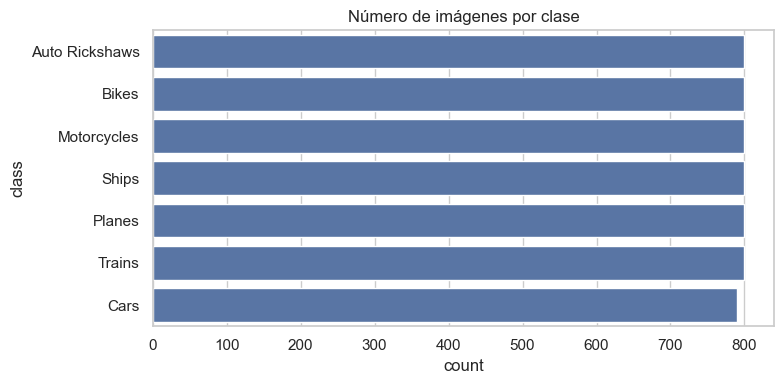

In [11]:
# 6) Distribución de clases
plt.figure(figsize=(8,4))
sns.countplot(data=df, y="class", order=df['class'].value_counts().index)
plt.title("Número de imágenes por clase")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "class_distribution.png"))
plt.show()


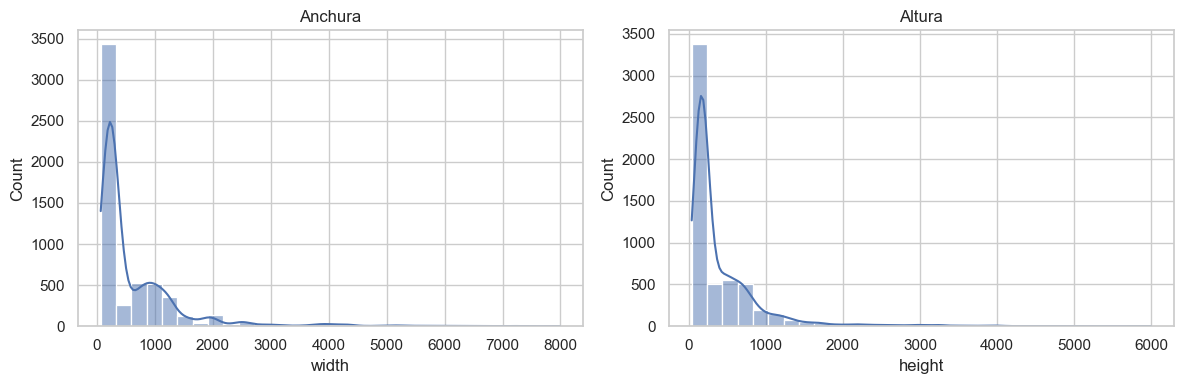

In [12]:
# 7) Histogramas de tamaño
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['width'],  bins=30, ax=axes[0], kde=True)
axes[0].set_title("Anchura")
sns.histplot(df['height'], bins=30, ax=axes[1], kde=True)
axes[1].set_title("Altura")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "size_histograms.png"))
plt.show()


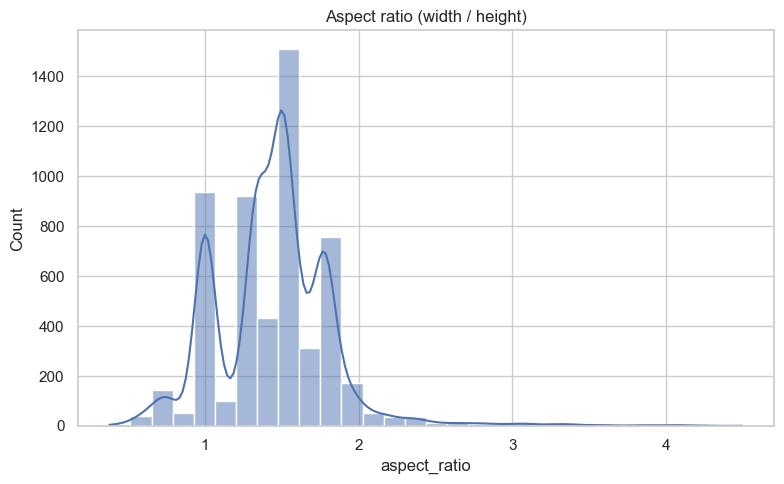

In [13]:
# 8) Aspect ratio
sns.histplot(df['aspect_ratio'], bins=30, kde=True)
plt.title("Aspect ratio (width / height)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aspect_ratio.png"))
plt.show()


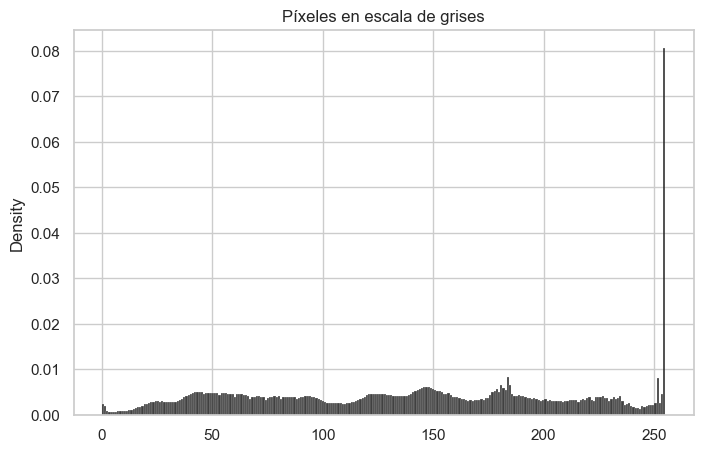

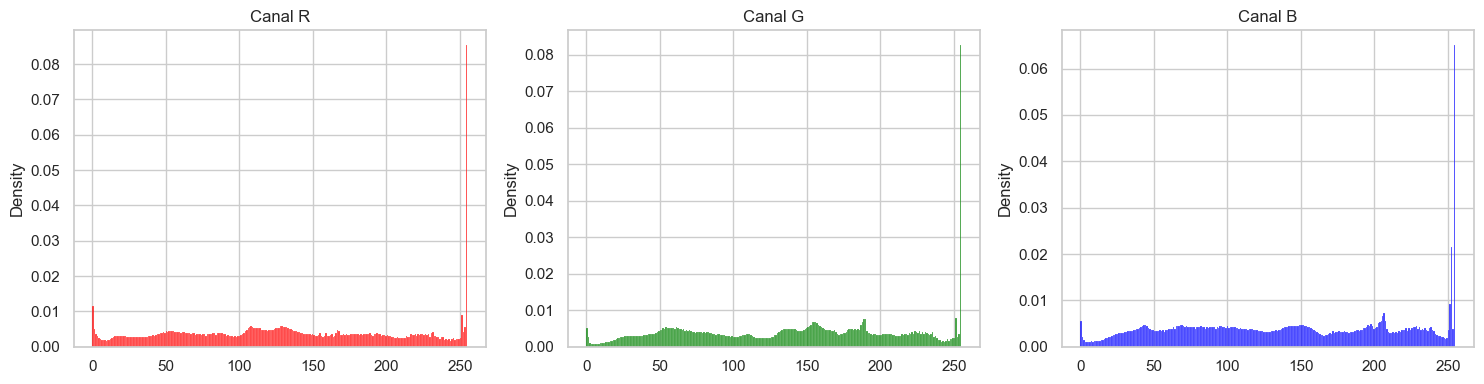

In [14]:
# 9) Histogramas de intensidad de píxeles
### Grises: convierte a L y concatena una muestra  
### RGB: un histograma por canal  

# Grises
sample = df['filepath'].sample(min(len(df), SAMPLE_SZ), random_state=1)
pixels = np.concatenate([np.asarray(Image.open(p).convert("L")).ravel() for p in sample])
sns.histplot(pixels, bins=256, stat="density", color="black")
plt.title("Píxeles en escala de grises")
plt.savefig(os.path.join(OUT_DIR, "hist_gray.png"))
plt.show()

# RGB
fig, axes = plt.subplots(1,3, figsize=(15,4))
for i, (col,clr) in enumerate(zip(["R","G","B"], ["red","green","blue"])):
    px = np.concatenate([np.asarray(Image.open(p))[:,:,i].ravel() for p in sample])
    sns.histplot(px, bins=256, stat="density", ax=axes[i], color=clr)
    axes[i].set_title(f"Canal {col}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "hist_rgb.png"))
plt.show()


In [15]:
# 10) Mosaicos de ejemplos por clase
def plot_mosaic(cls, n=MOSAIC_N):
    # paths = df.query("class==@cls")['filepath'].sample(n).values
    paths = df[df['class'] == cls]['filepath'].sample(n).values
    fig, axs = plt.subplots(3,3, figsize=(6,6))
    for ax, p in zip(axs.flatten(), paths):
        ax.imshow(Image.open(p).resize((100,100)))
        ax.axis("off")
    fig.suptitle(cls, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"mosaic_{cls}.png"))
    plt.close()

for cls in df['class'].unique():
    plot_mosaic(cls)


c:\Users\fdezc\anaconda3\envs\IMAGEN\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


                  R_mean    G_mean    B_mean     R_std     G_std     B_std
class                                                                     
Auto Rickshaws  0.528659  0.531410  0.491400  0.318113  0.302277  0.311924
Bikes           0.587630  0.574707  0.531976  0.291026  0.289505  0.304931
Cars            0.489417  0.477983  0.476652  0.322154  0.314307  0.323184
Motorcycles     0.515950  0.503863  0.495249  0.325251  0.324100  0.324572
Planes          0.525316  0.560754  0.608789  0.248138  0.245612  0.269315
Ships           0.459696  0.523107  0.569910  0.270035  0.241068  0.255854
Trains          0.443794  0.425596  0.412754  0.278745  0.275101  0.288585


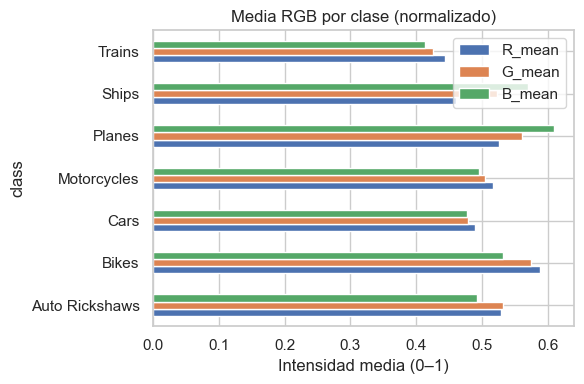

In [16]:
# 11) Media y desviación por canal RGB (resizing a 128×128)
from PIL import Image

STATS_SIZE = 128  # ancho/alto al que redimensionar para estadísitcas

stats = []
for cls in df['class'].unique():
    subset = df[df['class'] == cls]
    sample_paths = subset['filepath'].sample(
        min(200, len(subset)),
        random_state=42
    ).values

    # Cargamos, redimensionamos y normalizamos
    imgs = []
    for p in sample_paths:
        try:
            img = Image.open(p).convert('RGB').resize((STATS_SIZE, STATS_SIZE))
            arr = np.asarray(img, dtype=np.float32) / 255.0  # shape=(128,128,3)
            imgs.append(arr)
        except:
            continue

    if not imgs:
        continue

    arr_stack = np.stack(imgs, axis=0)  # ahora todas tienen shape (n,128,128,3)

    # Cálculo de medias y desviaciones
    means = arr_stack.mean(axis=(0,1,2))
    stds  = arr_stack.std(axis=(0,1,2))

    stats.append({
        'class':   cls,
        'R_mean':  means[0], 'G_mean': means[1], 'B_mean': means[2],
        'R_std':   stds[0],  'G_std':  stds[1],  'B_std':  stds[2]
    })

df_stats = pd.DataFrame(stats).set_index('class')
print(df_stats)

# (Opcional) Barplot de medias RGB
df_stats[['R_mean','G_mean','B_mean']].plot.barh(
    title="Media RGB por clase (normalizado)",
    figsize=(6,4)
)
plt.xlabel("Intensidad media (0–1)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rgb_means.png"))
plt.show()


C:\Users\glapu\.conda\envs\IMAGEN\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


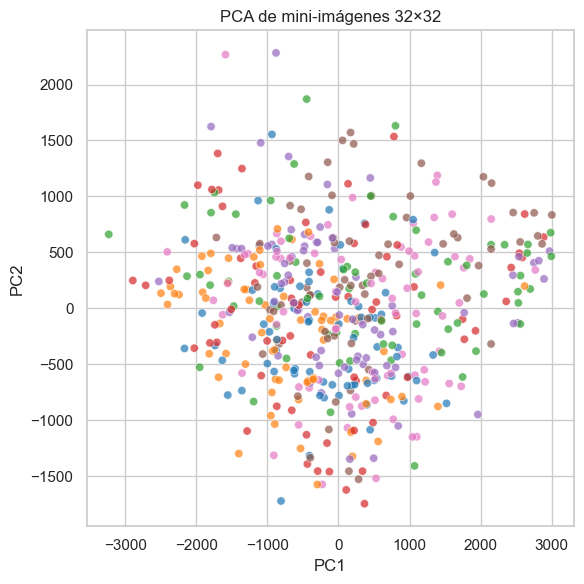

In [ ]:
# 12) PCA sobre mini-imágenes (versión robusta con try/except)
from sklearn.decomposition import PCA

PCA_SIZE = 32
MAX_SAMPLES = 500

# Muestreamos hasta MAX_SAMPLES ficheros
paths = df['filepath'].sample(min(len(df), MAX_SAMPLES), random_state=0).values

X_list = []
y_list = []
for p in paths:
    try:
        img = Image.open(p).convert('L').resize((PCA_SIZE, PCA_SIZE))
        arr = np.asarray(img, dtype=np.float32).ravel()  # vector de tamaño 1024
        X_list.append(arr)
        # etiqueta de clase:
        y_list.append(os.path.basename(os.path.dirname(p)))
    except Exception as e:
        # Saltar imágenes ilegibles
        continue

# Convertimos en array (shape: [n_samples, 1024])
X = np.stack(X_list, axis=0)
y = np.array(y_list)

# Aplicamos PCA a 2D
pca = PCA(2)
Z = pca.fit_transform(X)

# Y lo visualizamos
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=Z[:, 0],
    y=Z[:, 1],
    hue=y,
    legend=False,
    alpha=0.7,
    palette='tab10'
)
plt.title(f"PCA de mini-imágenes {PCA_SIZE}×{PCA_SIZE}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_32x32.png"))
plt.show()


## Preprocesamiento de Imágenes

A continuación creamos un pipeline completo que incluye:

1. Lectura, redimensionado y normalización  
2. Equalización de histograma global (YUV)  
3. CLAHE en canal L (LAB)  
4. División estratificada train/val/test  
5. Data augmentation con Keras  
6. Visualización de lotes aumentados  
7. Técnica extra: recorte automático por bordes (Canny)


In [17]:
# 1) Imports específicos de preprocesado
import cv2
from skimage import exposure
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reusar variables definidas antes:
# df        -> DataFrame con filepath y clase
# OUT_DIR   -> carpeta de salida
# IMG_SIZE  -> tamaño final (ancho=alto)
IMG_SIZE = 224
BATCH_SIZE = 32


In [18]:
# 2) Función de preprocesamiento individual
def preprocess_image(path,
                     img_size=IMG_SIZE,
                     equalize=True,
                     clahe=True):
    # 1) Leer BGR → RGB y redimensionar
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    
    # 2) Equalización global en canal Y (YUV)
    if equalize:
        yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
        img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    
    # 3) CLAHE en canal L (LAB)
    if clahe:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        clahe_obj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        lab[:, :, 0] = clahe_obj.apply(lab[:, :, 0])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # 4) Normalizar a [0,1]
    img = img.astype('float32') / 255.0
    return img


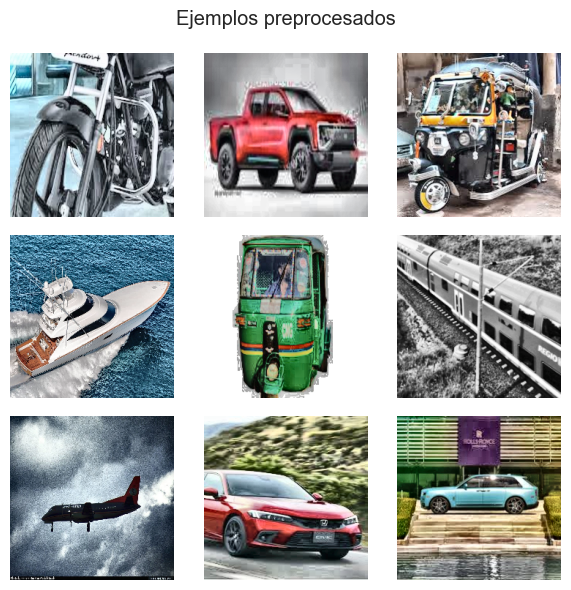

In [19]:
# 3) Mostrar ejemplos preprocesados
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, p in zip(axes.flatten(),
                df['filepath'].sample(9, random_state=1)):
    ax.imshow(preprocess_image(p))
    ax.axis('off')
plt.suptitle("Ejemplos preprocesados")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "preprocessed_examples.png"))
plt.show()


In [20]:
# 4) División estratificada train/val/test (60/20/20)
paths  = df['filepath'].values
labels = df['class'].values

p_temp, test_paths,   l_temp, test_labels = train_test_split(
    paths, labels,
    test_size=0.20,
    stratify=labels,
    random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    p_temp, l_temp,
    test_size=0.25,   # 0.25×0.80 = 0.20
    stratify=l_temp,
    random_state=42
)
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 3354, Val: 1118, Test: 1118


In [21]:
# 5) Data Augmentation con CLAHE + normalización completa en preprocessing_function

import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------------------------------------------
# Función que aplica CLAHE (OpenCV) y normaliza a float32 [0,1]
# -------------------------------------------------------------------
def clahe_and_normalize(img):
    """
    img: array RGB uint8 [0–255] (lo que entrega flow_from_dataframe)
    Devuelve: float32 RGB [0–1], con CLAHE aplicado en L (LAB)
    """
    # 1) Asegurarnos de trabajar con uint8
    img_uint8 = np.clip(img, 0, 255).astype('uint8')
    # 2) Convertir a LAB
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    # 3) Aplicar CLAHE sobre canal L
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    # 4) Volver a RGB
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    # 5) Normalizar a [0,1]
    return rgb.astype('float32') / 255.0

# -------------------------------------------------------------------
# Generadores sin rescale: toda la normalización dentro de la función
# -------------------------------------------------------------------
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    preprocessing_function=clahe_and_normalize,
    rescale=None      # Importante: quitamos el rescale, ya lo hacemos arriba
)

val_datagen = ImageDataGenerator(
    preprocessing_function=lambda img: img.astype('float32')/255.0,
    rescale=None
)

# -------------------------------------------------------------------
# Convertimos rutas y etiquetas a DataFrame para flow_from_dataframe
# -------------------------------------------------------------------
df_train = pd.DataFrame({'filepath': train_paths, 'class': train_labels})
df_val   = pd.DataFrame({'filepath':   val_paths,   'class': val_labels})

# -------------------------------------------------------------------
# Creamos los iteradores de Keras
# -------------------------------------------------------------------
train_gen = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3354 validated image filenames belonging to 7 classes.
Found 1116 validated image filenames belonging to 7 classes.


c:\Users\fdezc\anaconda3\envs\IMAGEN\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


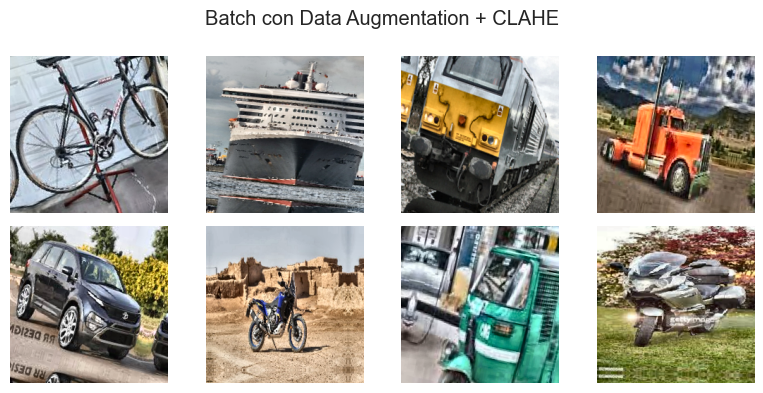

In [22]:
# 6) Ver un batch aumentado
x_batch, y_batch = next(train_gen)
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
for img, ax in zip(x_batch[:8], axes.flatten()):
    ax.imshow(img)
    ax.axis('off')
plt.suptitle("Batch con Data Augmentation + CLAHE")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "augmented_batch.png"))
plt.show()


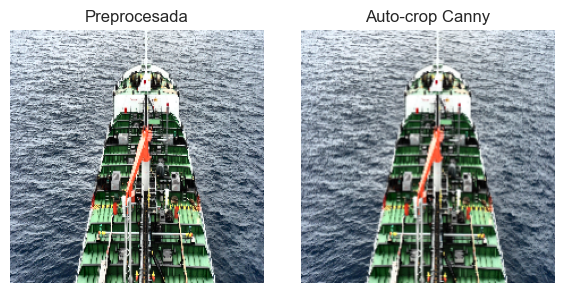

In [23]:
# 7) Técnica extra: recorte automático usando bordes (Canny)
def auto_crop_edges(img_arr, low=100, high=200):
    """
    img_arr: array RGB normalizado [0,1], shape=(H,W,3)
    devuelve recorte centrado en la caja de bordes detectados, redimensionado a IMG_SIZE
    """
    # Pasar a escala de grises y uint8
    gray = (img_arr * 255).astype('uint8')
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, low, high)

    ys, xs = np.where(edges > 0)
    if ys.size and xs.size:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()
        crop = img_arr[y1:y2, x1:x2]
        return cv2.resize((crop*255).astype('uint8'), (IMG_SIZE, IMG_SIZE)) / 255.0
    else:
        return img_arr

# Ejemplo de recorte:
p0 = df['filepath'].sample(1, random_state=0).iloc[0]
orig = preprocess_image(p0)
crop = auto_crop_edges(orig)
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(orig); ax[0].set_title("Preprocesada")
ax[1].imshow(crop); ax[1].set_title("Auto-crop Canny")
for a in ax: a.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "auto_crop_example.png"))
plt.show()


## Machine Learning Clásico

Extraemos **hand-crafted features** de las imágenes:
- Histograma de color RGB
- HOG (Histogram of Oriented Gradients)
- LBP (Local Binary Patterns)

Entrenamos un **SVM** con pipeline de escalado, validamos en el set de validación y evaluamos finalmente en el test.  
Mostramos matriz de confusión y report de clasificación (incluye sensibilidad = recall).


In [24]:
# 1) Imports específicos
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Reusar variables del notebook:
# train_paths, val_paths, test_paths
# train_labels, val_labels, test_labels
# IMG_SIZE (224 por ejemplo)


In [25]:
# 2) Funciones de extracción de features

def color_histogram(img, bins=16):
    """
    Histograma normalizado por canal RGB.
    img: array uint8 [0–255], shape=(H,W,3)
    devuelve vector length=3*bins, suma=1.
    """
    hists = []
    for i in range(3):
        hist,_ = np.histogram(img[:,:,i], bins=bins, range=(0,255))
        hists.append(hist)
    feature = np.concatenate(hists).astype('float32')
    return feature / feature.sum()

def extract_hog(img):
    """
    HOG sobre escala de grises de la imagen.
    img: uint8 o float [0–1], shape=(H,W,3)
    devuelve vector.
    """
    # convertir a float y gris
    if img.dtype != np.float32 and img.dtype != np.float64:
        im = img.astype('float32')/255.0
    else:
        im = img
    gray = rgb2gray(im)
    return hog(
        gray,
        orientations=9,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm='L2-Hys'
    )

def extract_lbp(img, P=8, R=1):
    """
    LBP uniforme + histograma normalizado.
    img: uint8 o float [0–1], shape=(H,W,3)
    devuelve vector length=P+2.
    """
    # gris
    if img.dtype != np.float32 and img.dtype != np.float64:
        im = img.astype('float32')/255.0
    else:
        im = img
    gray = rgb2gray(im)
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    n_bins = P + 2
    hist,_ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype('float32')
    return hist / hist.sum()


In [26]:
# 3) Construcción robusta de matrices de features

def build_feature_matrix(paths):
    feats = []
    valid_paths = []
    for p in paths:
        # Leer imagen
        img = cv2.imread(p)
        if img is None:
            print(f"No se pudo leer: {p}, saltando")
            continue
        # Convertir BGR→RGB y redimensionar
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        except Exception as e:
            print(f"Error procesando {p}: {e}, saltando")
            continue

        # Extraer features
        ch = color_histogram(img, bins=16)
        hg = extract_hog(img)
        lb = extract_lbp(img, P=8, R=1)

        feats.append(np.hstack([ch, hg, lb]))
        valid_paths.append(p)

    X = np.array(feats, dtype='float32')
    return X, valid_paths

# Ahora obtenemos X e, igualmente, rutas válidas para indexar etiquetas
X_train, train_paths_valid = build_feature_matrix(train_paths)
X_val,   val_paths_valid   = build_feature_matrix(val_paths)
X_test,  test_paths_valid  = build_feature_matrix(test_paths)

# Ajustamos las etiquetas para que cuadren con los paths leídos
y_train = np.array([train_labels[train_paths.tolist().index(p)] 
                    for p in train_paths_valid])
y_val   = np.array([val_labels[  val_paths.tolist().index(p)] 
                    for p in val_paths_valid])
y_test  = np.array([test_labels[test_paths.tolist().index(p)] 
                    for p in test_paths_valid])

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ",  y_test.shape)

c:\Users\fdezc\anaconda3\envs\IMAGEN\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


No se pudo leer: ./data/vehicle/Vehicles\Planes\Plane (43).gif, saltando
X_train: (3354, 6142) y_train: (3354,)
X_val:   (1117, 6142) y_val:   (1117,)
X_test:  (1118, 6142) y_test:  (1118,)


In [35]:
# 4) Pipeline + entrenamiento SVM

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

# Entreno sobre train, ajusto hyperparámetro si quiero usando X_val
clf.fit(X_train, y_train)

# Validación
y_val_pred = clf.predict(X_val)
print("Val Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (val):")
print(classification_report(y_val, y_val_pred))


Val Accuracy: 0.8182632050134289

Classification Report (val):
                precision    recall  f1-score   support

Auto Rickshaws       0.83      0.82      0.83       160
         Bikes       0.99      0.90      0.94       160
          Cars       0.78      0.75      0.76       158
   Motorcycles       0.78      0.84      0.81       160
        Planes       0.82      0.82      0.82       159
         Ships       0.75      0.83      0.79       160
        Trains       0.79      0.78      0.78       160

      accuracy                           0.82      1117
     macro avg       0.82      0.82      0.82      1117
  weighted avg       0.82      0.82      0.82      1117



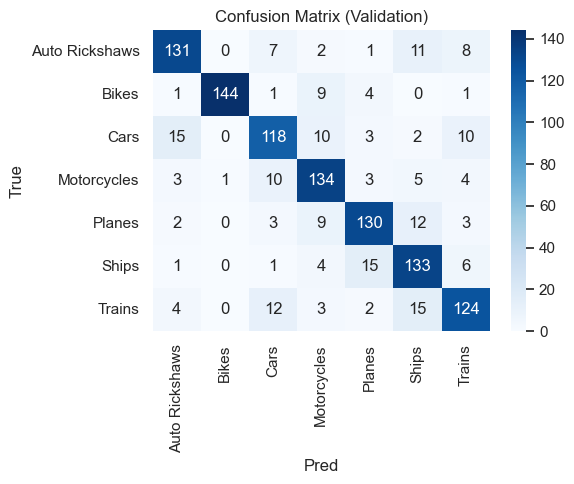

In [36]:
# 5) Matriz de confusión (validación)

cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=clf.classes_,
    yticklabels=clf.classes_,
    cmap='Blues'
)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'cm_val.png'))
plt.show()


Test Accuracy: 0.8282647584973166

Classification Report (test):
                precision    recall  f1-score   support

Auto Rickshaws       0.82      0.79      0.81       160
         Bikes       1.00      0.91      0.95       160
          Cars       0.76      0.78      0.77       158
   Motorcycles       0.84      0.86      0.85       160
        Planes       0.83      0.80      0.81       160
         Ships       0.77      0.86      0.81       160
        Trains       0.80      0.80      0.80       160

      accuracy                           0.83      1118
     macro avg       0.83      0.83      0.83      1118
  weighted avg       0.83      0.83      0.83      1118



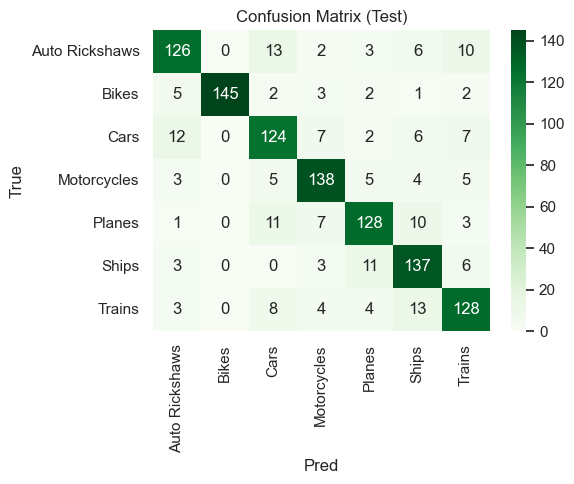

In [37]:
# 6) Evaluación final en el set de test

y_test_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (test):")
print(classification_report(y_test, y_test_pred))

cm2 = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm2, annot=True, fmt='d',
    xticklabels=clf.classes_,
    yticklabels=clf.classes_,
    cmap='Greens'
)
plt.ylabel('True')
plt.xlabel('Pred')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'cm_test.png'))
plt.show()


## Deep Learning

#### 1. Clasificación con CNN From Scratch  
- Definición del modelo  
- Entrenamiento y curvas de accuracy/loss  
- Comprobación de la predicción de una imagen

#### 2. Transfer Learning + Fine-tuning (EfficientNetB0)  
- Definición del modelo  
- Entrenamiento y curvas de accuracy/loss  
- Comprobación de la predicción de una imagen


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split



In [25]:
## Preparación de datos para PyTorch

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Cargamos todo el conjunto
full_dataset = datasets.ImageFolder('data/vehicle/Vehicles', transform=transform)

# Calculamos tamaños para el split
n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

# Split aleatorio
train_data, val_data, test_data = random_split(
    full_dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # para reproducibilidad
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [ ]:
# MODELO FROM SCRATCH

# CNN simple desde cero
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entrenamiento con curvas
train_acc, val_acc, train_loss, val_loss = [], [], [], []
for epoch in range(10):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))

    # Validación
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc.append(correct / total)
    val_loss.append(running_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Acc {train_acc[-1]:.2f}, Val Acc {val_acc[-1]:.2f}")

# Curvas
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.tight_layout()
plt.show()


In [5]:
## PRUEBA DE PREDICCIÓN CON UNA IMAGEN NUEVA

# Ruta a la imagen que quieres predecir
image_path = 'data/vehicle/tests/rayo_mcqueen.jpeg'  # Ruta a la imagen que quieres predecir

# Preprocesado igual al del dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Cargar imagen
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # [1, C, H, W]

# Mover al mismo dispositivo que el modelo
input_tensor = input_tensor.to(device)
model.eval()

# Predicción
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

# Obtener la clase predicha
predicted_class = full_dataset.classes[predicted.item()]
print(f'Predicción: {predicted_class}')


Predicción: Cars


Epoch 1: Train Acc 0.66, Val Acc 0.75
Epoch 2: Train Acc 0.77, Val Acc 0.76
Epoch 3: Train Acc 0.80, Val Acc 0.76
Epoch 4: Train Acc 0.81, Val Acc 0.77
Epoch 5: Train Acc 0.82, Val Acc 0.76
Epoch 6: Train Acc 0.82, Val Acc 0.77
Epoch 7: Train Acc 0.83, Val Acc 0.77
Epoch 8: Train Acc 0.83, Val Acc 0.79
Epoch 9: Train Acc 0.85, Val Acc 0.77
Epoch 10: Train Acc 0.84, Val Acc 0.79


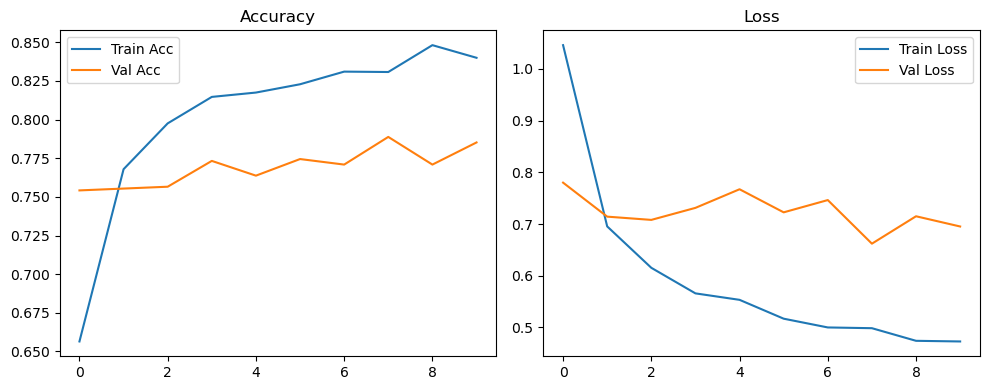

In [ ]:
## MODELO PREENTRENADO (ResNet50)

from torchvision import models

# Cargamos resnet18 preentrenada
model_pre = models.resnet50(pretrained=True)   
for param in model_pre.parameters():
    param.requires_grad = False  # congelamos capas base

# Reemplazamos la última capa para adaptarla a nuestro número de clases
num_features = model_pre.fc.in_features
model_pre.fc = nn.Linear(num_features, len(full_dataset.classes))

model_pre = model_pre.to(device)
optimizer = optim.Adam(model_pre.fc.parameters(), lr=1e-3)

# Entrenamiento con curvas
train_acc, val_acc, train_loss, val_loss = [], [], [], []
for epoch in range(10):
    model_pre.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_pre(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))

    # Validación
    model_pre.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_pre(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc.append(correct / total)
    val_loss.append(running_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Train Acc {train_acc[-1]:.2f}, Val Acc {val_acc[-1]:.2f}")

# Curvas
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.tight_layout()
plt.show()



In [8]:
## PRUEBA DE PREDICCIÓN CON UNA IMAGEN NUEVA

# Función para predecir una imagen individual
def predict_image(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]
    with torch.no_grad():
        output = model(input_tensor)
        predicted_idx = output.argmax(1).item()
    return class_names[predicted_idx]

# Ruta a una imagen que quieras probar (puede ser del mismo dataset)
image_path = 'data/vehicle/tests/rayo_mcqueen.jpeg'  # Ruta a la imagen que quieres predecir

# Usa el mismo transform que usaste en el entrenamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Llamada a la función
predicted_class = predict_image(model_pre, image_path, transform, full_dataset.classes)
print(f'Predicción: {predicted_class}')


Predicción: Cars


# IMAGE-TO-IMAGE: Generación de nuevas imágenes por categoría/clasificación.

## Generación de Imágenes por Categoría con Stable Diffusion

Este script utiliza el modelo preentrenado **Stable Diffusion v1.5** para generar imágenes sintéticas representativas de distintas clases de vehículos. La generación se realiza mediante *text-to-image* condicional: a partir de una descripción textual (prompt) basada en el nombre de la clase, se produce una imagen realista que refleja esa categoría.

### Características del código:
- Usa el modelo `runwayml/stable-diffusion-v1-5` de Hugging Face.
- Genera una imagen para cada una de las siguientes clases:
  - Auto Rickshaws
  - Bikes
  - Cars
  - Motorcycles
  - Planes
  - Ships
  - Trains
- Guarda las imágenes generadas en el directorio local `outputs/generated_images`.

In [ ]:
# Importar librerías
import torch
from diffusers import StableDiffusionPipeline
import os


In [ ]:
# Cargar modelo preentrenado
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Clases que quieres generar
categories = [
    "Auto Rickshaws",
    "Bikes",
    "Cars",
    "Motorcycles",
    "Planes",
    "Ships",
    "Trains"
]

# Crear carpeta destino
output_dir = "outputs/generated_images"
os.makedirs(output_dir, exist_ok=True)

# Generar una imagen por categoría
for cls in categories:
    prompt = f"A realistic photo of a {cls.lower()}"
    image = pipe(prompt).images[0]
    filename = f"gen_{cls.replace(' ', '_').lower()}.png"
    image.save(os.path.join(output_dir, filename))
    print(f"Imagen generada: {filename}")

print("Imágenes generadas en la carpeta:", output_dir)

In [12]:
#image captioning

In [11]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# Ruta a la imagen a describir
image_path = "data/vehicle/tests/Desierto-moto.jpg" 

# Cargar modelo y processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Cargar imagen
image = Image.open(image_path).convert('RGB')

# Preprocesar y generar caption
inputs = processor(images=image, return_tensors="pt").to(device)
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)

print(f"📝 Descripción generada: {caption}")


📝 Descripción generada: a man riding a motorcycle through the desert


# IMAGE to TEXT: Text extraction with Tesseract

- En esta celda se utiliza la librería `pytesseract`, un wrapper de Python para Tesseract OCR, con el objetivo de extraer texto desde una imagen. Este tipo de técnica es útil dentro del análisis de datos no estructurados cuando se trabaja con imágenes que contienen texto (por ejemplo, carteles, matrículas, documentos escaneados, etc.).

- **NOTA**: Será necesaria primero la descarga del programa Tesseract y se recomienda instalarlo en la misma ruta que se muestra en el código.

In [ ]:
import pytesseract
from PIL import Image

# Solo necesario en Windows — indica el path a tesseract.exe
pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"  # Ajustar esto si fuese necesario

# Ruta a tu imagen
image_path = "data/vehicle/tests/ferrari_desc.png"

# Cargar imagen
image = Image.open(image_path).convert("RGB")

# OCR
text = pytesseract.image_to_string(image)

print("📝 Texto extraído:")
print(text)


📝 Texto extraído:
Ferrari
Fabricante de automdviles

Ferrari es un fabricante de automéviles superdeportivos
con sede en Maranello, provincia de Médena, en la regién
de Emilia-Romaia, Italia.

Source: Wikipedia

